# Simulation Model

In [51]:
# -------------------------------------------------------------------------------
# import packages
import import_ipynb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# -------------------------------------------------------------------------------
# import scripts
from data_processing import hiring_data

## Create Model Interview Invitation

- lets think about if the model is trained with a fair dataset but the input is not fair since more male will apply for those positions.
- This model is always taking the whole dataset/ test set as input. No subset of the data is taken.

### Logistitic regression model (no fairness)

In [52]:
# data to X and y
X = hiring_data.drop(columns=['decision', 'Id', 'company'])
y = hiring_data['decision']

# test train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple logistic regression model
model = LogisticRegression(max_iter=4000)
model_standard = model.fit(X_train, y_train)

# Get prediction probabilities for the positive class (decision = 1)
y_probs = model_standard.predict_proba(X_test)[:, 1]
y_pred = model_standard.predict(X_test)

# count values
y_pred_count = pd.DataFrame(y_pred).value_counts()
y_pred_count

# confusion matrix
confusion_matrix(y_test, y_pred)

# scores f1, accuracy, precision, recall
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.83       567
           1       0.60      0.37      0.46       233

    accuracy                           0.74       800
   macro avg       0.69      0.63      0.65       800
weighted avg       0.72      0.74      0.72       800



In [53]:
model.coef_

array([[ 0.03203658,  0.00342265, -0.03528292, -0.04361612,  0.10187028,
        -0.16576751, -0.229147  ,  0.40699566, -0.29476946,  1.15435541,
        -0.55297195,  0.7331408 ]])

### Logistitic regression model (with Demographic parity)

In [54]:
import numpy as np

# Assuming y_pred are your predicted probabilities and sensitive_feature indicates group membership
def fairness_loss(y_true, y_pred, sensitive_feature):
    positive_rate_group1 = np.mean(y_pred[sensitive_feature == 1])
    positive_rate_group2 = np.mean(y_pred[sensitive_feature == 2])

    # Add penalty based on difference in positive rates
    parity_penalty = np.abs(positive_rate_group1 - positive_rate_group2)
    
    # Traditional logistic loss function (cross-entropy)
    log_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    # Combine with fairness penalty (you can weigh this penalty)
    total_loss = log_loss + 0.1 * parity_penalty
    return total_loss


In [55]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression
from fairlearn.reductions import ErrorRate

# Define model
model = LogisticRegression(max_iter=4000)

# Fairness constraint: Demographic Parity
constraint = DemographicParity()

# Apply fairness-aware training using ExponentiatedGradient (a reduction method)
fair_model = ExponentiatedGradient(model, constraints=constraint)
fair_model.fit(X_train, y_train, sensitive_features=X_train['gender'])

# Get predictions from fairness-aware model
y_pred_fair = fair_model.predict(X_test)


### Logistic Regression Model (Reweighted)

In [56]:
# Get indices for male and female
male_idx = X_test['gender'] == 1  # Assuming 1 = Male
female_idx = X_test['gender'] == 0  # Assuming 0 = Female

# Compute selection rates
male_selection_rate = np.mean(y_pred[male_idx])
female_selection_rate = np.mean(y_pred[female_idx])

# Compute Disparate Impact (should ideally be close to 1)
disparate_impact = female_selection_rate / male_selection_rate if male_selection_rate > 0 else np.nan

In [57]:
# Compute inverse sample weights
weights = np.where(X_train['gender'] == 0, male_selection_rate / female_selection_rate, 1)

# Train model with sample weights
model_reweight = model.fit(X_train, y_train, sample_weight=weights)

# Get predictions on the test set
y_pred2 = model_reweight.predict(X_test)
y_probs2 = model_reweight.predict_proba(X_test)[:, 1] 

### Add Outcome to Dataframe

In [58]:
# add to X test the values of y_pred
X_test['y_pred'] = y_pred
X_test['y_pred2'] = y_pred2
X_test['y_pred3'] = y_pred_fair

### Look at Selection Rates of Interview

In [59]:
# Compute selection rates again
male_selection_rate_post = np.mean(y_pred_fair[male_idx])
female_selection_rate_post = np.mean(y_pred_fair[female_idx])

# Compute Disparate Impact after debiasing
disparate_impact_post = female_selection_rate_post / male_selection_rate_post if male_selection_rate_post > 0 else np.nan

# Print results before and after debiasing
print("=== Before Debiasing ===")
print(f"Male Selection Rate: {male_selection_rate:.2f}")
print(f"Female Selection Rate: {female_selection_rate:.2f}")
print(f"Disparate Impact: {disparate_impact:.2f}")

print("\n=== After Debiasing ===")
print(f"Male Selection Rate: {male_selection_rate_post:.2f}")
print(f"Female Selection Rate: {female_selection_rate_post:.2f}")
print(f"Disparate Impact: {disparate_impact_post:.2f}")

=== Before Debiasing ===
Male Selection Rate: 0.23
Female Selection Rate: 0.11
Disparate Impact: 0.48

=== After Debiasing ===
Male Selection Rate: 0.20
Female Selection Rate: 0.17
Disparate Impact: 0.86


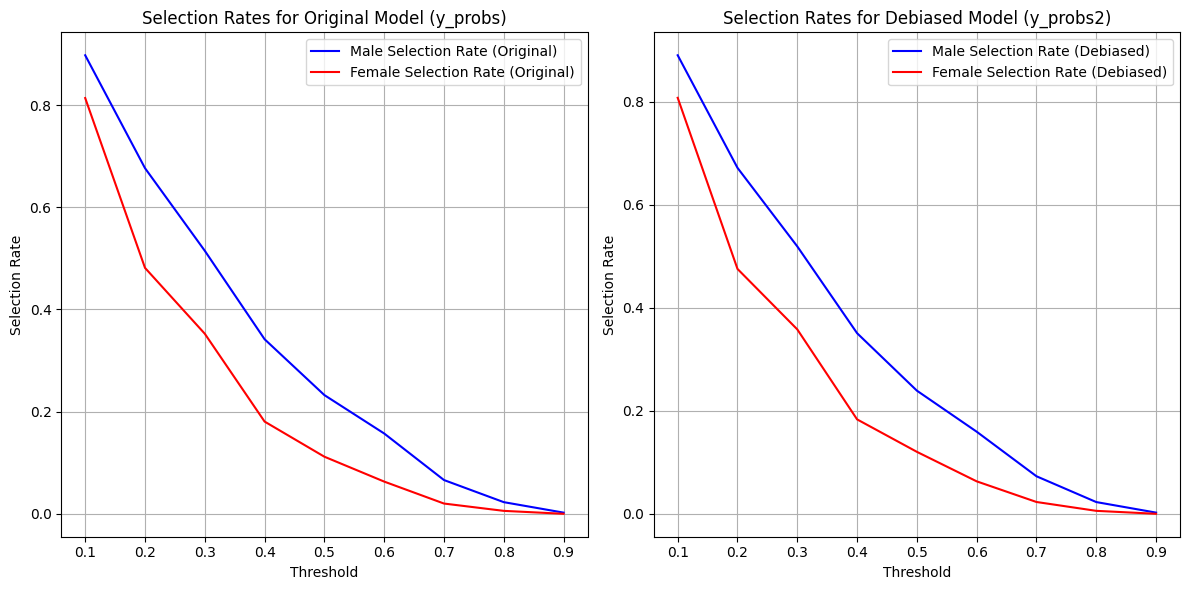

In [60]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Extract probabilities for male and female applicants from both models
male_probs1 = y_probs[X_test['gender'] == 1]
female_probs1 = y_probs[X_test['gender'] == 0]

male_probs2 = y_probs2[X_test['gender'] == 1]
female_probs2 = y_probs2[X_test['gender'] == 0]

# Thresholds from 0.1 to 0.9
thresholds = np.linspace(0.1, 0.9, 9)  
male_selection_rates_1 = []
female_selection_rates_1 = []
male_selection_rates_2 = []
female_selection_rates_2 = []

# Calculate selection rates for both models at each threshold
for threshold in thresholds:
    male_preds_1 = (male_probs1 >= threshold).astype(int)
    female_preds_1 = (female_probs1 >= threshold).astype(int)
    male_preds_2 = (male_probs2 >= threshold).astype(int)
    female_preds_2 = (female_probs2 >= threshold).astype(int)

    male_selection_rate_1 = np.mean(male_preds_1)
    female_selection_rate_1 = np.mean(female_preds_1)
    male_selection_rate_2 = np.mean(male_preds_2)
    female_selection_rate_2 = np.mean(female_preds_2)

    male_selection_rates_1.append(male_selection_rate_1)
    female_selection_rates_1.append(female_selection_rate_1)
    male_selection_rates_2.append(male_selection_rate_2)
    female_selection_rates_2.append(female_selection_rate_2)

# Plot selection rates for both models
plt.figure(figsize=(12, 6))

# Plot for the original model (y_probs)
plt.subplot(1, 2, 1)
plt.plot(thresholds, male_selection_rates_1, label='Male Selection Rate (Original)', color='blue')
plt.plot(thresholds, female_selection_rates_1, label='Female Selection Rate (Original)', color='red')
plt.xlabel('Threshold')
plt.ylabel('Selection Rate')
plt.title('Selection Rates for Original Model (y_probs)')
plt.legend(loc='best')
plt.grid(True)

# Plot for the debiased model (y_probs2)
plt.subplot(1, 2, 2)
plt.plot(thresholds, male_selection_rates_2, label='Male Selection Rate (Debiased)', color='blue')
plt.plot(thresholds, female_selection_rates_2, label='Female Selection Rate (Debiased)', color='red')
plt.xlabel('Threshold')
plt.ylabel('Selection Rate')
plt.title('Selection Rates for Debiased Model (y_probs2)')
plt.legend(loc='best')
plt.grid(True)

# Display both plots
plt.tight_layout()
plt.show()


## Create Parameter for Hiring after Interview

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def biased_selection(data, male_selection_prob=0.7, female_selection_prob=0.3, 
                     overall_selection_rate=0.25, gender_col='gender', decision_col='decision'):
    """
    Implements a biased selection algorithm where:
    - Only considers candidates where the decision column value is 1.
    - Selects 25% of these pre-selected candidates.
    - Each male has a 70% chance of selection and each female has a 30% chance.

    Parameters:
    data (pandas.DataFrame): DataFrame with gender and decision columns
    male_selection_prob (float): Probability of selecting a male candidate (default 0.7)
    female_selection_prob (float): Probability of selecting a female candidate (default 0.3)
    overall_selection_rate (float): Proportion of pre-selected candidates to select (default 0.25)
    gender_col (str): Name of the gender column in the dataframe (default 'gender')
    decision_col (str): Name of the decision column in the dataframe (default 'decision')

    Returns:
    tuple: (Number of males selected, Number of females selected)
    """
    # Filter candidates where decision column is 1
    candidates = data[data[decision_col] == 1].copy()
    
    if len(candidates) == 0:
        return 0, 0  # No selection possible
    
    # Calculate how many candidates to select
    n_to_select = int(len(candidates) * overall_selection_rate)

    # Assign selection probabilities based on gender
    candidates['selection_prob'] = candidates[gender_col].apply(lambda x: male_selection_prob if x == 1 else female_selection_prob)

    # Perform weighted random selection
    selected_indices = np.random.choice(
        candidates.index, 
        size=n_to_select, 
        replace=False, 
        p=candidates['selection_prob'] / candidates['selection_prob'].sum()
    )

    # Count selected males and females
    selected = candidates.loc[selected_indices]
    male_selected = sum(selected[gender_col] == 1)
    female_selected = sum(selected[gender_col] == 0)
    
    return male_selected, female_selected

## Hiring Result

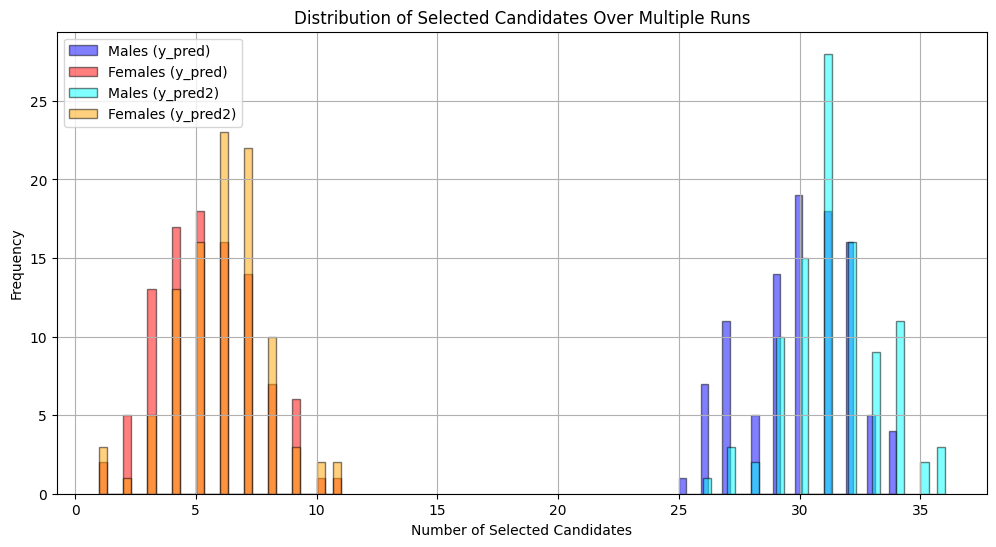

In [62]:
# Run multiple times and store results
num_iterations = 100
male_counts_pred, female_counts_pred = [], []
male_counts_pred2, female_counts_pred2 = [], []

for _ in range(num_iterations):
    male1, female1 = biased_selection(X_test, decision_col='y_pred')
    male2, female2 = biased_selection(X_test, decision_col='y_pred2')
    
    male_counts_pred.append(male1)
    female_counts_pred.append(female1)
    
    male_counts_pred2.append(male2)
    female_counts_pred2.append(female2)

# Plot the distributions
plt.figure(figsize=(12, 6))

plt.hist(male_counts_pred, bins=30, alpha=0.5, label="Males (y_pred)", color='blue', edgecolor='black')
plt.hist(female_counts_pred, bins=30, alpha=0.5, label="Females (y_pred)", color='red', edgecolor='black')

plt.hist(male_counts_pred2, bins=30, alpha=0.5, label="Males (y_pred2)", color='cyan', edgecolor='black')
plt.hist(female_counts_pred2, bins=30, alpha=0.5, label="Females (y_pred2)", color='orange', edgecolor='black')

plt.xlabel("Number of Selected Candidates")
plt.ylabel("Frequency")
plt.title("Distribution of Selected Candidates Over Multiple Runs")
plt.legend()
plt.grid(True)

plt.show()


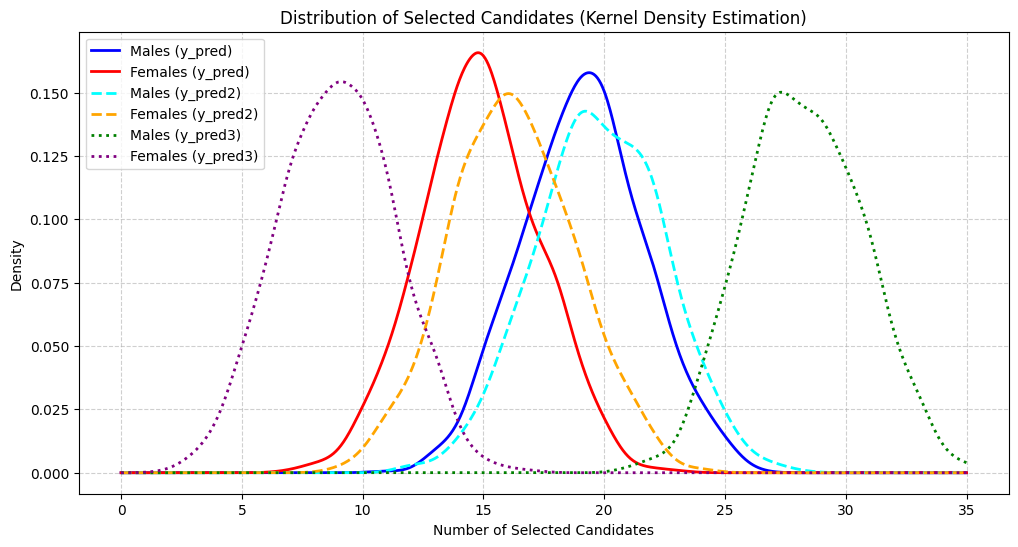

In [65]:
from scipy.stats import gaussian_kde

num_iterations = 1000
male_counts_pred, female_counts_pred = [], []
male_counts_pred2, female_counts_pred2 = [], []
male_counts_pred3, female_counts_pred3 = [], []

for _ in range(num_iterations):
    male1, female1 = biased_selection(X_test, male_selection_prob=0.3, female_selection_prob=0.7, decision_col='y_pred')
    male2, female2 = biased_selection(X_test, male_selection_prob=0.3, female_selection_prob=0.7, decision_col='y_pred2')
    male3, female3 = biased_selection(X_test,  male_selection_prob=0.7, female_selection_prob=0.3, decision_col='y_pred3')
    
    male_counts_pred.append(male1)
    female_counts_pred.append(female1)
    
    male_counts_pred2.append(male2)
    female_counts_pred2.append(female2)

    male_counts_pred3.append(male3)
    female_counts_pred3.append(female3)

# Kernel Density Estimation (KDE) for smooth distribution curves
kde_male_pred = gaussian_kde(male_counts_pred, bw_method='silverman')
kde_female_pred = gaussian_kde(female_counts_pred, bw_method='silverman')
kde_male_pred2 = gaussian_kde(male_counts_pred2, bw_method='silverman')
kde_female_pred2 = gaussian_kde(female_counts_pred2, bw_method='silverman')
kde_male_pred3 = gaussian_kde(male_counts_pred3, bw_method='silverman')
kde_female_pred3 = gaussian_kde(female_counts_pred3, bw_method='silverman')

# Create a range of x-values to plot the KDE
x_values = np.linspace(0, max(max(male_counts_pred), max(female_counts_pred), 
                              max(male_counts_pred2), max(female_counts_pred2), 
                              max(male_counts_pred3), max(female_counts_pred3)
                              ), 1000)

# Plot the KDE as line charts
plt.figure(figsize=(12, 6))

plt.plot(x_values, kde_male_pred(x_values), label="Males (y_pred)", color='blue', lw=2)
plt.plot(x_values, kde_female_pred(x_values), label="Females (y_pred)", color='red', lw=2)

plt.plot(x_values, kde_male_pred2(x_values), label="Males (y_pred2)", color='cyan', lw=2, linestyle="--")
plt.plot(x_values, kde_female_pred2(x_values), label="Females (y_pred2)", color='orange', lw=2, linestyle="--")

plt.plot(x_values, kde_male_pred3(x_values), label="Males (y_pred3)", color='green', lw=2, linestyle=":")
plt.plot(x_values, kde_female_pred3(x_values), label="Females (y_pred3)", color='purple', lw=2, linestyle=":")

plt.xlabel("Number of Selected Candidates")
plt.ylabel("Density")
plt.title("Distribution of Selected Candidates (Kernel Density Estimation)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()